# Autograd & MLP Implementation
- Autograd is a automatic differentiation library. We are implementing a simple version of autograd here. 
- Multilayer Perceptron is a neural network that takes vectors as inputs and uses backpropagation for training. We are implementing a MLP library on top of autograd here. Autograd makes backpropagation incredibly easy to implement.
- Inspiration: Andrej Karpathy's tutorial https://www.youtube.com/watch?v=VMj-3S1tku0

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
# Autograd implementation
class Value:
    def __init__(self, data, _children=(), _operation='', label=''):
        self.data = data
        self._children = set(_children)   # _children is used for backward tracing
        self._operation = _operation    # _operation is only used to draw the graph and debug
        self.label = label   # label is only used to draw the graph and debug
        self.grad = 0
        self._backward = lambda: None

        
    def __repr__(self):
        return f"Value object: data={self.data}"
    
    
    def __add__(self, other):
        if not isinstance(other, Value): other = Value(other)  # to allow 'a+1'
        out = Value(self.data + other.data, (self, other), "+")
        
        # if the add operation is used to define out, then out is set to have the corresponding _backward function
        def _backward():
            self.grad += out.grad  # use += because we need to accumulate gradient if a var is used multiple times
            other.grad += out.grad
        out._backward = _backward  # define the custom _backward function for out
        
        return out
    
    
    def __mul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += out.grad * other.data  
            other.grad += out.grad * self.data
        out._backward = _backward 
        
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "exponent needs to be a value"
        out = Value(math.pow(self.data, other), (self, ), f"**{other}")  #(self) is not a tuple, but (self ,) is
        
        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
        out._backward = _backward
        
        return out
        
        
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    
    def tanh(self):
        return ((2*self).exp() - 1) / ((2*self).exp() + 1)
    
    
    # enable 1+a to work. Python errors while calling 1+a so it calls a.__radd__(1)
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-1)*other
    
    def __rsub__(self, other):
        return self - other
    
    def __neg__(self):
        return (-1)*self
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    
    def backward(self):
        visited = set()
        order = []
        # pre order traversal doesn't work because the sequence of visiting the children matters
        # use topological sort and reverse
        def topo_sort(self):
            if self not in visited:
                visited.add(self)
                for c in self._children:
                    topo_sort(c)
                order.append(self)
        topo_sort(self)
        
        self.grad = 1.0
        for node in reversed(order):
            node._backward()
    
    

In [81]:
# generate a graph for visualization
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._children:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._operation:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._operation, label = n._operation)
          # and connect this node to it
          dot.edge(uid + n._operation, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

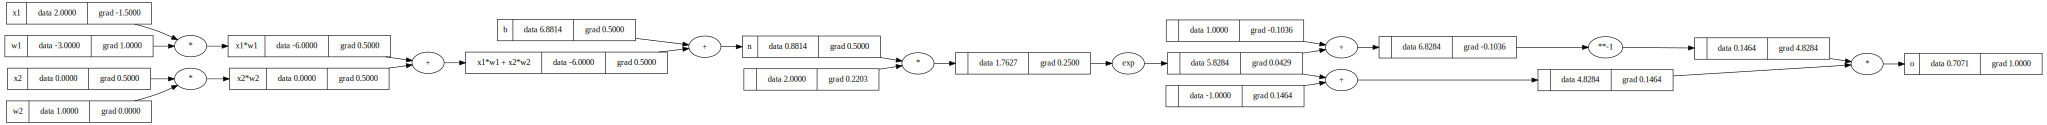

In [82]:
# test output

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
# o = n.tanh()  -> should generate the same result
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [79]:
# MLP implementation
class Neuron:
    def __init__(self, dim_in):
        # initialize weight to be small random numbers the same size as the input data dimension
        # use Value objects for backprop tracing purposes!
        self.w = [Value(random.uniform(-1, 1)) for _ in range(dim_in)]
        self.b = Value(random.uniform(-1, 1))
    
    # returns output of the neuron
    # x is a vector with dim_in
    def __call__(self, x):
        # w * x + b
        agg = sum([xi*wi for xi, wi in zip(x, self.w)]) + self.b
        return agg.tanh()
    
    def parameters(self):
        # all weights and the bias are parameters to learn
        return self.w + [b]
    
class Layer:
    # dim_in is the size of a vector x (or previous layer's size), dim_out is the # neurons in a layer
    def __init__(self, dim_in, dim_out):
        self.neurons = [Neuron(dim_in) for _ in range(dim_out)]
        
    def __call__(self, x):
        pred = [n(x) for n in self.neurons]  
        if len(pred) == 1: return pred[0]  # return a scalar instead of a list with len=1 if we are at the last layer
        return pred
        
    def parameters(self):
        param = []
        for n in self.neurons:
            param.extend(n.parameters())
        return param
    
    
class MLP:  # multi-layered perceptron
    # layer_dims is a list containing #neurons in each layer
    def __init__(self, dim_in, layer_dims):
        dims = [dim_in] + layer_dims
        self.layers = [Layer(dims[i], dims[i+1]) for i in range(len(layer_dims))]
        
    def __call__(self, x):
        for layer in self.layers:
            # call layer on x, then call the next layer on that output, recurse for all layers
            x = layer(x)
        return x
    
    def parameters(self):
        param = []
        for layer in self.layers:
            param.extend(layer.parameters())
        return param
            

In [69]:
# sample training data set
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [77]:
# Gradient Descent
mlp = MLP(3, [4,4,1])  # example MLP
step_size = 0.1

for k in range(30):
    # forward pass
    ypred = []
    for x in xs:
        ypred.append(mlp(x))
    
    # calculate loss
    loss = sum((y-yp)**2 for y, yp in zip(ys, ypred))
    
    # backward pass
    loss.backward()
    
    # update params
    for p in mlp.parameters():
        p.data += - step_size * p.grad   # need to set p.data because otherwise p value is not saved!
        p.grad = 0   # zero out the gradients before next iteration!
    
    print(k, loss.data)

0 5.649297682359109
1 0.7176423496583855
2 0.2277523072676748
3 0.1293244312922301
4 0.09025721060907785
5 0.06869109884964326
6 0.05514007033944935
7 0.04588813473689597
8 0.03919497432659558
9 0.03414178979108311
10 0.030199639242855354
11 0.027043355523757966
12 0.024462462185625852
13 0.022314930279014954
14 0.020501572925713446
15 0.018951099004829657
16 0.017610996381062588
17 0.01644175984957066
18 0.0154131179336158
19 0.014501496895969735
20 0.013688274302646786
21 0.0129585501723346
22 0.012300265597910028
23 0.011703559644832016
24 0.011160292793150091
25 0.010663688807896827
26 0.010208062150603098
27 0.009788608064744905
28 0.009401239184383955
29 0.0090424570941736
